# Data Challenge

## The Idea

One of my hobbies is baking. I love to bake cakes, cookies, tarts, and all those delicious treats. This hobby sparked my idea for this challenge. We all know about the apple, butter, carrot, or milk in the back of the fridge that is about to spoil. You can still eat it, but it doesn't look appetizing, or it's too much to use in a short amount of time. For this, I thought it would be a good challenge to create an app that could identify the ingredients you upload with a picture and use that list of ingredients to find a recipe so you don't have to throw those ingredients away.

### Approach

My approach to this challenge is to start with a CNN model that can identify the ingredients in a picture that you upload. From this model, an ingredient list will be made. This list will then be used in an NLP model to find a recipe that you could make to use those ingredients. For this, I spent some time finding images I can use to create this CNN model. I found a dataset that seems to be good enough for now at [Roboflow.](https://universe.roboflow.com/myproject-ko746/fridgedetection/dataset/3)

After having found the data I started with loading the images and research how to best train a model to detect the ingredients in the dataset. 

## Loading the packages 

Starting of with loading the packages that i am going to use in the notebook. 

In [29]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import tensorflow as tf
from collections import Counter

from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input


## Loading the data

In [30]:
dataset_root = "FridgeDetection_data"
splits = ["train", "test", "valid"]

def load_data(split):
    image_dir = os.path.join(dataset_root, split, "images")
    label_dir = os.path.join(dataset_root, split, "labelTxt")
    
    images, labels = [], []
    for file in os.listdir(image_dir):
        if file.lower().endswith((".jpg", ".png")):
            img_path = os.path.join(image_dir, file)
            label_path = os.path.join(label_dir, os.path.splitext(file)[0] + ".txt")
            
            images.append(cv2.imread(img_path))
            labels.append(open(label_path).read() if os.path.exists(label_path) else None)
    
    return images, labels

data = {split: dict(zip(["images", "labels"], load_data(split))) for split in splits}

# Print summary
for split in splits:
    print(f"{split.capitalize()}: Loaded {len(data[split]['images'])} images and {len(data[split]['labels'])} labels.")


Train: Loaded 1521 images and 1521 labels.
Test: Loaded 73 images and 73 labels.
Valid: Loaded 145 images and 145 labels.


## data understanding

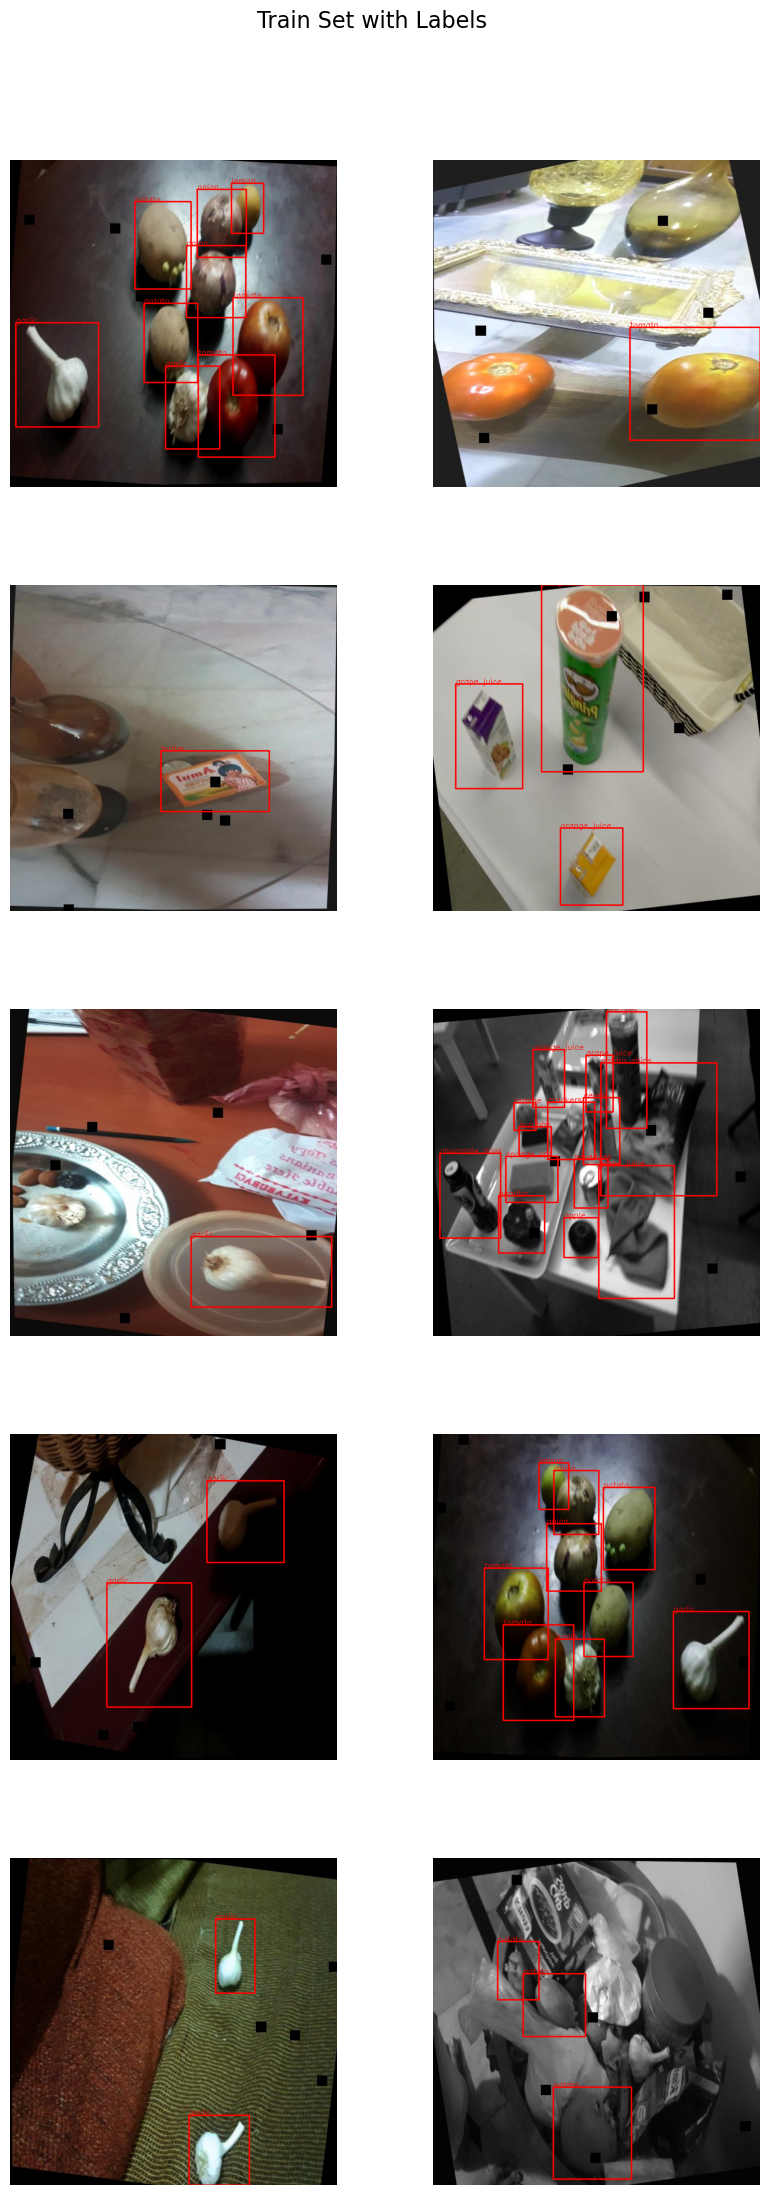

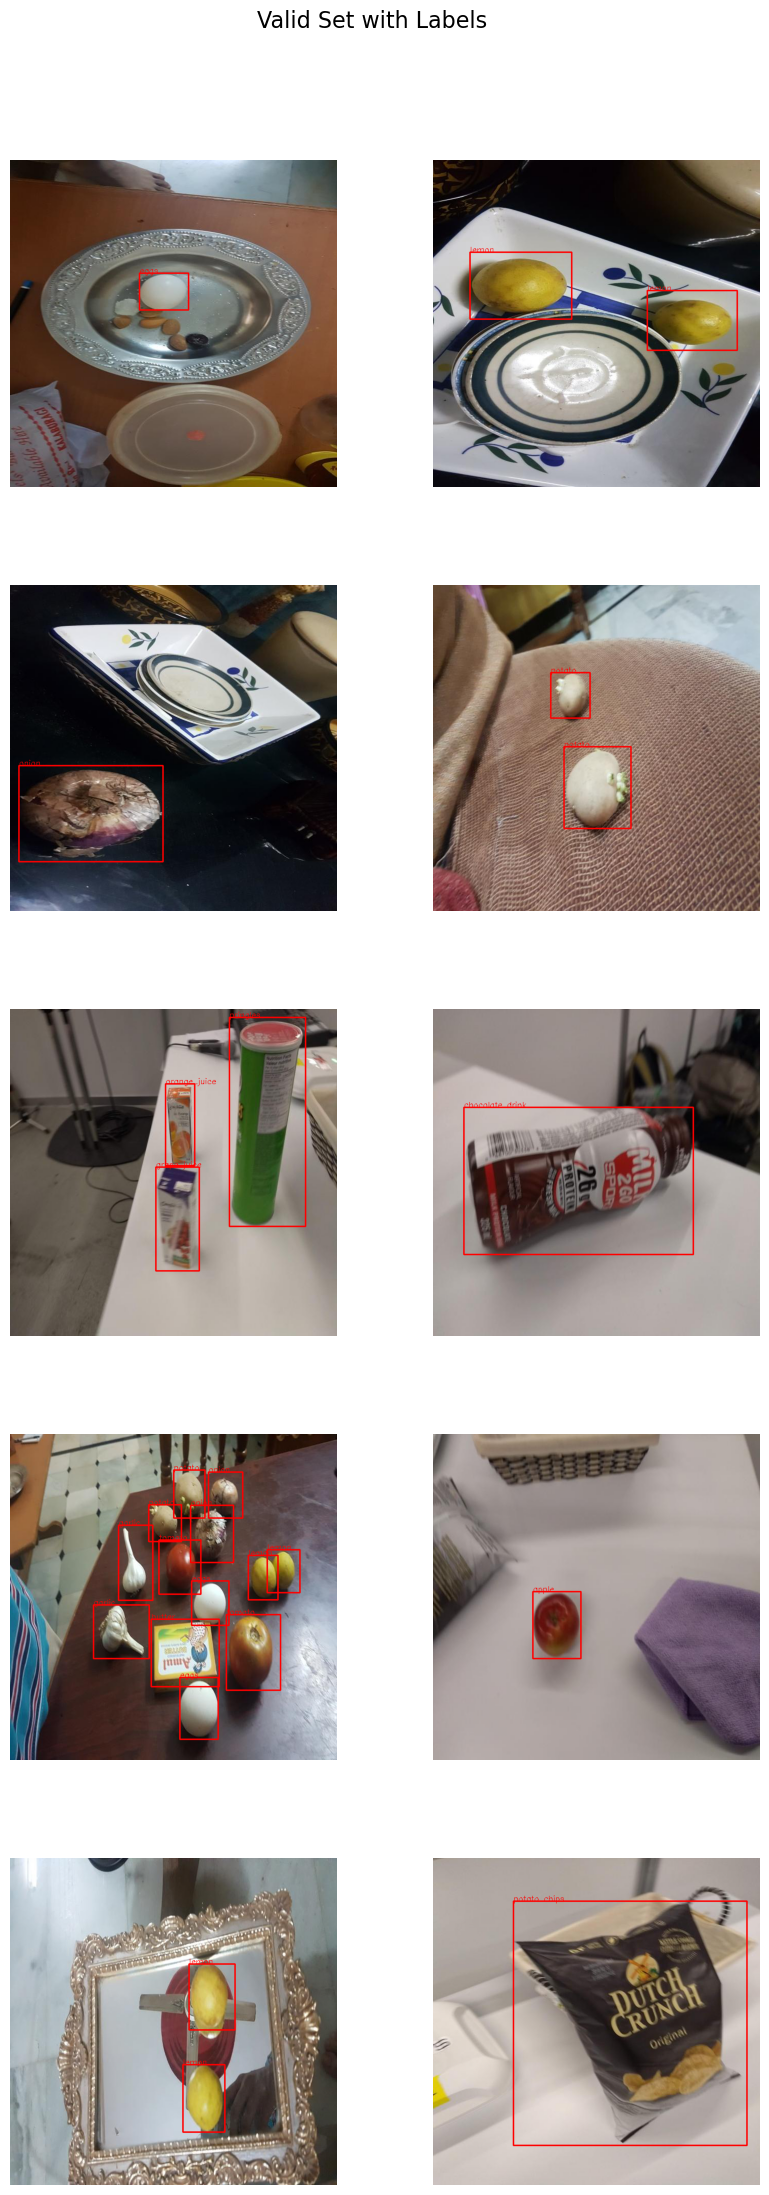

In [31]:
def plot_images_with_labels(images, labels, title, num_images=10, max_columns=2):
    combined = list(zip(images, labels))
    random.shuffle(combined)
    images, labels = zip(*combined[:num_images])

    num_rows = (len(images) + max_columns - 1) // max_columns
    fig, axes = plt.subplots(num_rows, max_columns, figsize=(10, 5 * num_rows))
    axes = axes.flatten() if num_images > 1 else [axes]

    for ax, img, label_text in zip(axes, images, labels):
        img = img.copy()
        if label_text:
            for line in label_text.strip().splitlines():
                parts = line.split()
                if len(parts) >= 9:
                    coords = list(map(int, parts[:8]))
                    label = parts[8]
                    pts = np.array(coords).reshape((4, 2))
                    cv2.polylines(img, [pts], isClosed=True, color=(0, 0, 255), thickness=2)
                    cv2.putText(img, label, tuple(pts[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis("off")

    # Hide unused subplots
    for ax in axes[len(images):]:
        ax.axis("off")

    fig.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.92, hspace=0.3)
    plt.show()

# Example usage
plot_images_with_labels(data['train']['images'], data['train']['labels'], "Train Set with Labels")
plot_images_with_labels(data['valid']['images'], data['valid']['labels'], "Valid Set with Labels")


In [32]:
# Function to count labels
def count_labels(data):
    label_counts = Counter()
    for split in data:
        for label_data in data[split]['labels']:
            if label_data:
                for line in label_data.splitlines():
                    parts = line.split()
                    if len(parts) >= 9:
                        label = parts[8]
                        label_counts[label] += 1
    return label_counts

# Count labels across all splits
label_counts = count_labels(data)

# Print the counts
for label, count in label_counts.items():
    print(f"{label}: {count}")

crackers: 189
sausages: 359
sprite: 186
chocolate_drink: 363
coke: 218
orange: 222
apple: 169
paprika: 238
noodles: 191
cereal: 231
grape_juice: 254
basket: 92
orange_juice: 210
scrubby: 238
sponge_opl: 200
cloth_opl: 92
potato_chips: 191
pringles: 213
potato: 251
onion: 344
garlic: 224
butter: 152
eggs: 347
tomato: 199
lemon: 206
tray: 98
help_me_carry_opl: 37


In [33]:
# Check the size of the first image in the training set
image_shape = data['train']['images'][0].shape
print(f"Image size: {image_shape}")

Image size: (640, 640, 3)


## Prepropecessing 

In [34]:
# Ensure the input data is preprocessed
X_train_preprocessed = preprocess_input(np.array(data['train']['images']))
X_val_preprocessed = preprocess_input(np.array(data['valid']['images']))
y_train = data['train']['labels']
y_val = data['valid']['labels']
X_test_preprocessed = preprocess_input(np.array(data['test']['images']))
y_test = data['test']['labels']

In [35]:
def resize(img):
    # Convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Normalize pixel values to [0, 1]
    img = img.astype("float32") / 255.0
    # Clip values to ensure they are within the valid range [0, 1] for floats
    img = np.clip(img, 0.0, 1.0)
    # Resize image
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
    return img

# Apply preprocessing to all sets
X_train = np.array([resize(img) for img in X_train_preprocessed])
X_val = np.array([resize(img) for img in X_val_preprocessed])
X_test = np.array([resize(img) for img in X_test_preprocessed])

In [36]:
def resize_labels(labels, original_size, new_size):
    """
    Resize label coordinates proportionally to the new image size.

    Args:
        labels (list): List of label strings.
        original_size (tuple): Original image size (width, height).
        new_size (tuple): New image size (width, height).

    Returns:
        list: Resized labels with integer coordinates.
    """
    resized_labels = []
    scale_x = new_size[0] / original_size[0]
    scale_y = new_size[1] / original_size[1]
    
    for label_data in labels:
        if label_data:
            resized_label_data = []
            for line in label_data.splitlines():
                parts = line.split()
                if len(parts) >= 9:
                    x1, y1, x2, y2, x3, y3, x4, y4, label = parts[:9]
                    coords = [int(int(p) * scale_x if i % 2 == 0 else int(p) * scale_y) for i, p in enumerate([x1, y1, x2, y2, x3, y3, x4, y4])]
                    resized_label_data.append(f"{coords[0]} {coords[1]} {coords[2]} {coords[3]} {coords[4]} {coords[5]} {coords[6]} {coords[7]} {label}")
            resized_labels.append("\n".join(resized_label_data))
        else:
            resized_labels.append(None)
    
    return resized_labels# Example usage

original_size = (640, 640)  # Assuming original images are 640x640
new_size = (224, 224)  # Resized images are 224x224

# Resize labels for train, validation, and test sets
resized_train_labels = resize_labels(y_train, original_size, new_size)
resized_val_labels = resize_labels(y_val, original_size, new_size)
resized_test_labels = resize_labels(y_test, original_size, new_size)

# Print a few examples to verify
print("Original label:", y_train[0])
print("Resized label:", resized_train_labels[0])


Original label: 121 107 522 107 522 418 121 418 crackers 0
Resized label: 42 37 182 37 182 146 42 146 crackers


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04056507..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.042593174..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06368705..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05440599..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06144396..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.030762283..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03439017..255.0].
Clip

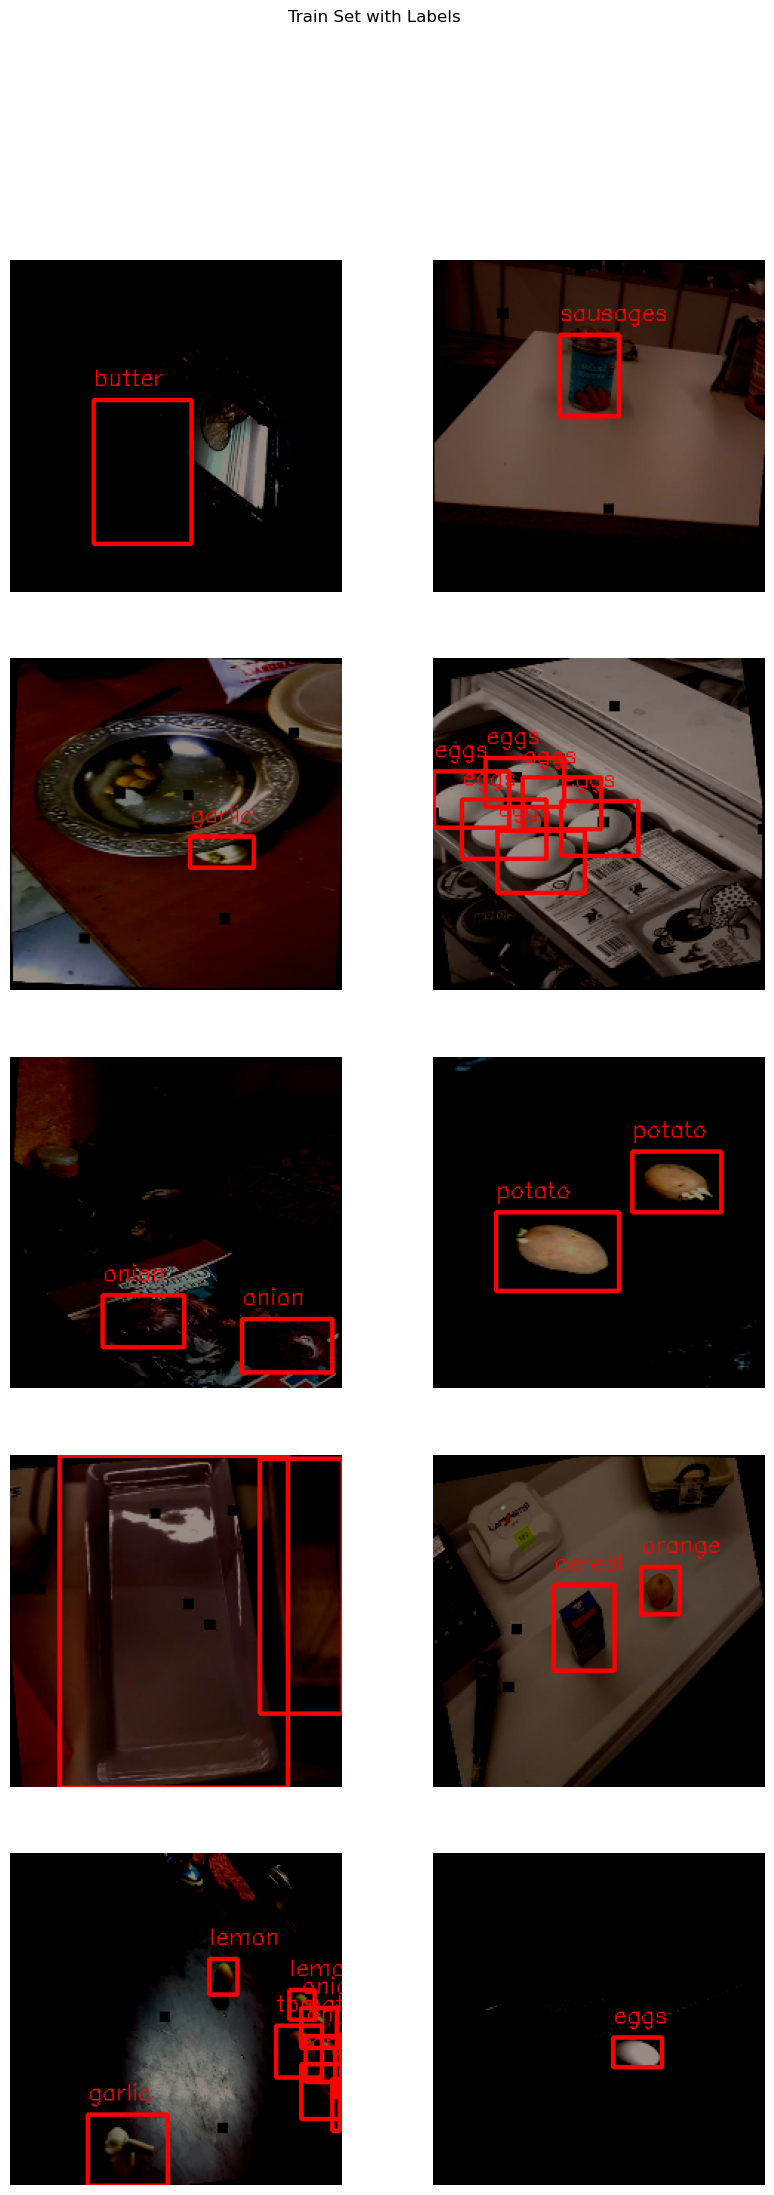

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05351461..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04559491..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03984811..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.045102388..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.051864993..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05315274..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.051676936..255.0].
Cli

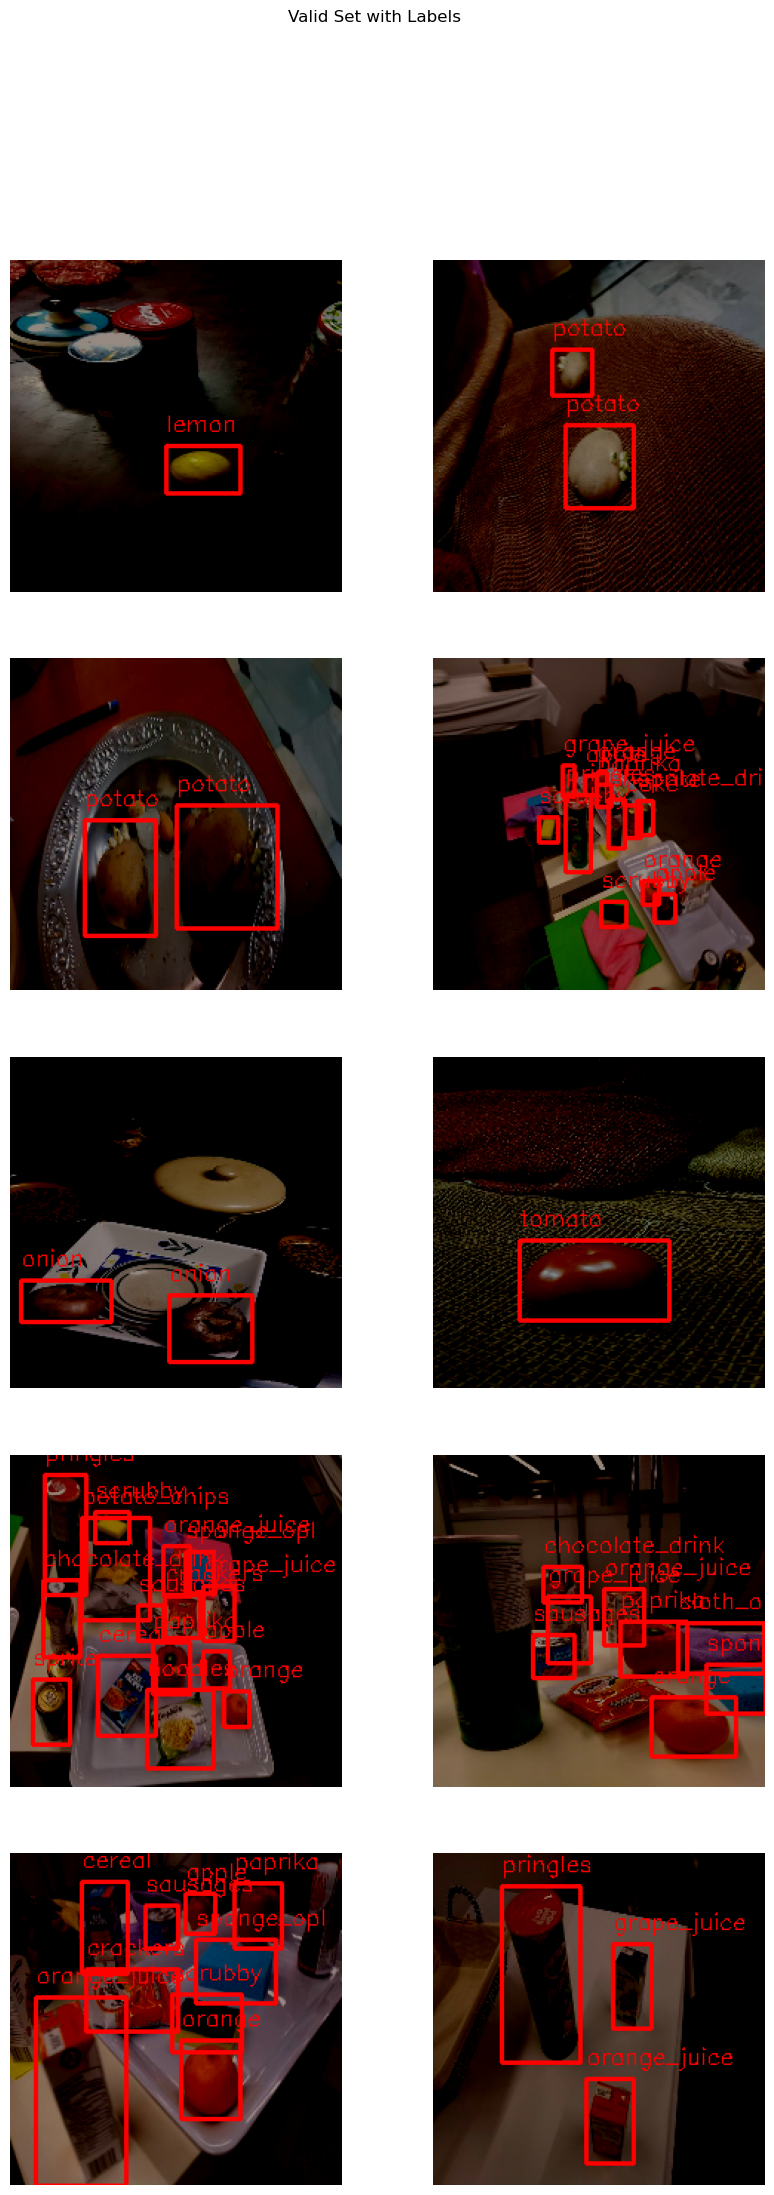

In [37]:
def plot_images_with_labels(images, labels, title, num_images=10, max_columns=2):
    # Shuffle images and labels together
    combined = list(zip(images, labels))
    random.shuffle(combined)
    images, labels = zip(*combined)
    
    num_rows = (min(num_images, len(images)) + max_columns - 1) // max_columns
    plt.figure(figsize=(10, 5 * num_rows))
    
    for i in range(min(num_images, len(images))):
        img = images[i].copy()  # Make a copy of the image to avoid modifying the original image
        if labels[i]:
            for line in labels[i].splitlines():
                parts = line.split()
                if len(parts) >= 9:
                    # Extract the coordinates and label
                    x1, y1, x2, y2, x3, y3, x4, y4, label = parts[:9]
                    
                    # Convert the coordinates to integers
                    x1, y1, x2, y2, x3, y3, x4, y4 = map(int, [x1, y1, x2, y2, x3, y3, x4, y4])
                    
                    # Draw the label text
                    cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
                    
                    # Draw the bounding box polygon
                    cv2.polylines(img, [np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], np.int32)], 
                                   isClosed=True, color=(0, 0, 255), thickness=2)
                
        
        # Plot the image
        plt.subplot(num_rows, max_columns, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB for displaying
        plt.axis("off")
    
    # Set title and show the plot
    plt.suptitle(title)
    plt.show()

# Plot 10 random images from the train set with labels
plot_images_with_labels(X_train, resized_train_labels, "Train Set with Labels")

# Plot 10 random images from the validation set with labels
plot_images_with_labels(X_val, resized_val_labels, "Valid Set with Labels")

y_train = resized_train_labels
y_val = resized_val_labels
y_test = resized_test_labels

In [38]:
# Preprocess labels into multi-hot encoded format
def encode_labels(labels, label_counts):
    label_to_index = {label: idx for idx, label in enumerate(label_counts.keys())}
    num_classes = len(label_counts)
    
    encoded_labels = []
    for label_data in labels:
        multi_hot = np.zeros(num_classes, dtype=np.float32)
        if label_data:
            for line in label_data.splitlines():
                parts = line.split()
                if len(parts) >= 9:
                    label = parts[8]
                    if label in label_to_index:
                        multi_hot[label_to_index[label]] = 1.0
        encoded_labels.append(multi_hot)
    return np.array(encoded_labels)

# Apply preprocessing to train, validation, and test labels
y_train_encoded = encode_labels(y_train, label_counts)
y_val_encoded = encode_labels(y_val, label_counts)
y_test_encoded = encode_labels(y_test, label_counts)

# Modeling


In [39]:
# Define the number of classes based on the label_counts
num_classes = len(label_counts)

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')  # sigmoid for multi-label
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fit the model with preprocessed labels
history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_val, y_val_encoded))

Epoch 1/50
48/48 [==============================] - 3s 53ms/step - loss: 0.3476 - accuracy: 0.0782 - val_loss: 0.2830 - val_accuracy: 0.0414
Epoch 2/50
48/48 [==============================] - 2s 51ms/step - loss: 0.2913 - accuracy: 0.0888 - val_loss: 0.2675 - val_accuracy: 0.1034
Epoch 3/50
48/48 [==============================] - 2s 51ms/step - loss: 0.2482 - accuracy: 0.1690 - val_loss: 0.2389 - val_accuracy: 0.1517
Epoch 4/50
48/48 [==============================] - 2s 51ms/step - loss: 0.1877 - accuracy: 0.3103 - val_loss: 0.2762 - val_accuracy: 0.1586
Epoch 5/50
48/48 [==============================] - 2s 52ms/step - loss: 0.1179 - accuracy: 0.4997 - val_loss: 0.3409 - val_accuracy: 0.1724
Epoch 6/50
48/48 [==============================] - 3s 52ms/step - loss: 0.0697 - accuracy: 0.5897 - val_loss: 0.4812 - val_accuracy: 0.1793
Epoch 7/50
48/48 [==============================] - 3s 53ms/step - loss: 0.0352 - accuracy: 0.6391 - val_loss: 0.6073 - val_accuracy: 0.1655
Epoch 8/50
48

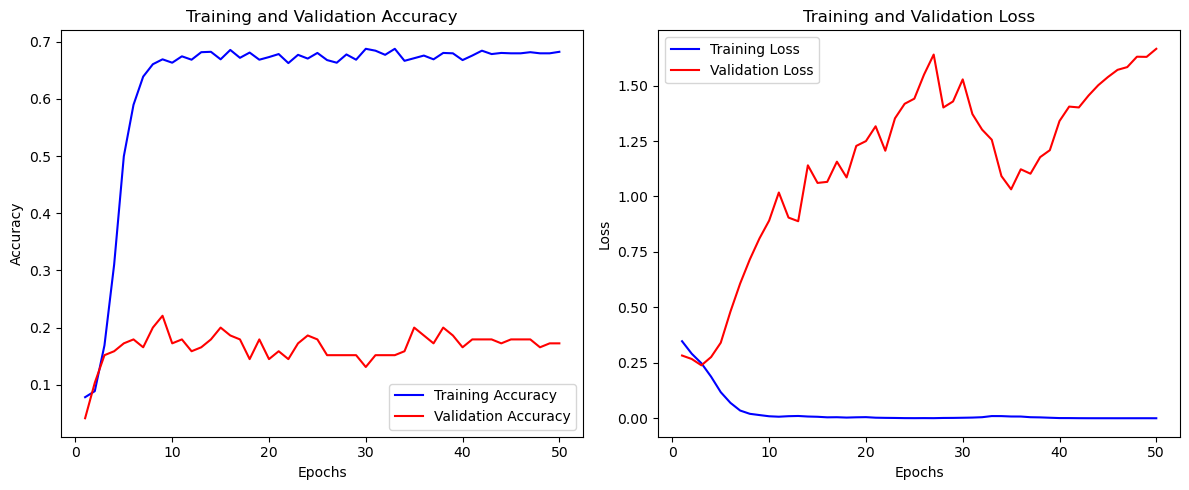

In [40]:
# Plot accuracy and loss graphs
def plot_training_history(history):
    # Extract accuracy and loss values
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function with the history object
plot_training_history(history)

Epoch 1/50
48/48 [==============================] - 3s 43ms/step - loss: 0.3814 - accuracy: 0.0934 - val_loss: 0.2130 - val_accuracy: 0.3034 - lr: 0.0010
Epoch 2/50
48/48 [==============================] - 2s 35ms/step - loss: 0.2575 - accuracy: 0.1847 - val_loss: 0.1848 - val_accuracy: 0.3586 - lr: 0.0010
Epoch 3/50
48/48 [==============================] - 2s 35ms/step - loss: 0.2152 - accuracy: 0.3031 - val_loss: 0.1689 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 4/50
48/48 [==============================] - 2s 35ms/step - loss: 0.1879 - accuracy: 0.3596 - val_loss: 0.1524 - val_accuracy: 0.3448 - lr: 0.0010
Epoch 5/50
48/48 [==============================] - 2s 35ms/step - loss: 0.1751 - accuracy: 0.3767 - val_loss: 0.1470 - val_accuracy: 0.4069 - lr: 0.0010
Epoch 6/50
48/48 [==============================] - 2s 35ms/step - loss: 0.1593 - accuracy: 0.4398 - val_loss: 0.1417 - val_accuracy: 0.3655 - lr: 0.0010
Epoch 7/50
48/48 [==============================] - 2s 35ms/step - loss: 0.1

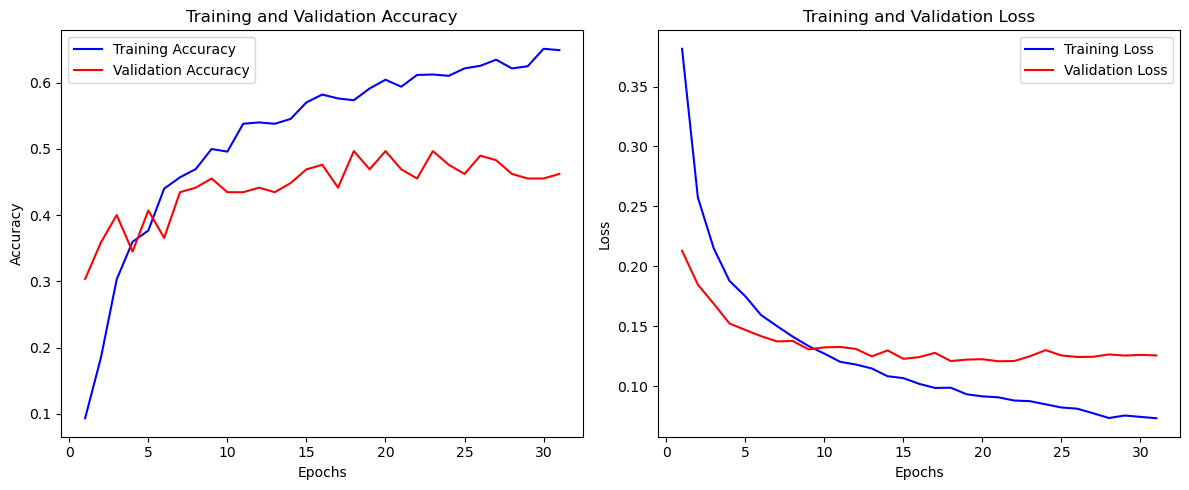

In [41]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze weights

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    # layers.Dense(64, activation='relu'),
    # layers.Dropout(0.5),
    # layers.Dense(32, activation='relu'),
    # layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid')

])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# Fit the model with preprocessed labels
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5)
]
history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_val, y_val_encoded), callbacks=callbacks)
# Plot accuracy and loss graphs
plot_training_history(history)

